In [1]:
import os
import matplotlib.pyplot as plt
from chalmers import holger as waxs_util
import importlib
import numpy as np
from scipy import signal
from scipy import fft


In this notebook we will first examine the intensities of each pixel in the sample and then look at how we can perform a Fourier transform and use signal processing techniques to get further insights of the sample.

# Intensity plot shape

In this chapter we will look at each pixel's (image) intensity plot over q to determine the homogeneity of the sample. The reason for that is that if we can get an overall understanding of the pixels of this sample, we can make conscious decisions about how we can analyze the sample further. For example if it turns out that the radially (azimuthally) integrated data of each pixel seem to have the same shape over the whole sample it will make sense to analyze the sample average. On the other hand, if we see variances over the sample it might require more rigorous investigation and a sample average might be misleading when interpreting the sample.

The first step is to load the data. Here we use a slightly modified version of the `load_data` function to decrease the amount of data loaded into memory and to find which pixels that are the background plastic film. See the documentation of the function for more details.

In [2]:
file_path_integrated = os.getcwd().replace('chalmers', 'data/scan-0035_lambda_integrated.h5')
file_path_master = os.getcwd().replace('chalmers', 'data/scan-0035.h5')

# Specify which azimuthal angles to load.
max_azimuthal_degree = 100
min_azimuthal_degree = 80

# The importlib library allows a smoother developing process. By reloading the external library every run it makes sure any changes to the library is run. Without it, one needs to restart the notebook every time a change is made to the library. 
importlib.reload(waxs_util)

data = waxs_util.load_data(file_path_integrated, file_path_master, max_azimuthal_degree, min_azimuthal_degree)

The first thing we do is to subtract the background mean from the $I$ matrix.

In [3]:
data['I'] = data['I'] - data['background_mean']

The rest of this chapter we will examine three pixels. However, the code is written such that any number of pixels can be entered for the analysis. Define the pixels that you wish to examine. The count starts at 0 in the upper left corner and then follows to the right following the snake scan.

The plot of the sample images show which pixels are selected. 

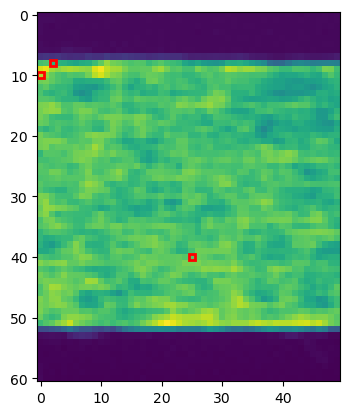

In [4]:
pixels = [402, 500, 2025]

I_flipped = np.reshape(np.mean(data['I'], axis=1), (data['shape'][0], data['shape'][1]))
I_flipped[1::2,:] = I_flipped[1::2,::-1]
pixels_flipped = np.zeros(data['I'].shape[0])
pixels_flipped[pixels] = 1
pixels_flipped = np.reshape(pixels_flipped, (data['shape'][0], data['shape'][1]))
pixels_flipped[1::2,:] = pixels_flipped[1::2,::-1]

plt.imshow(I_flipped)
ax = plt.gca()

pixels_to_frame = pixels_flipped.nonzero()
for i in range(len(pixels_to_frame[0])):
    y = pixels_to_frame[0][i]
    x = pixels_to_frame[1][i]
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    
plt.show()

Now lets inspect the intensity plots for each of the background corrected pixels.

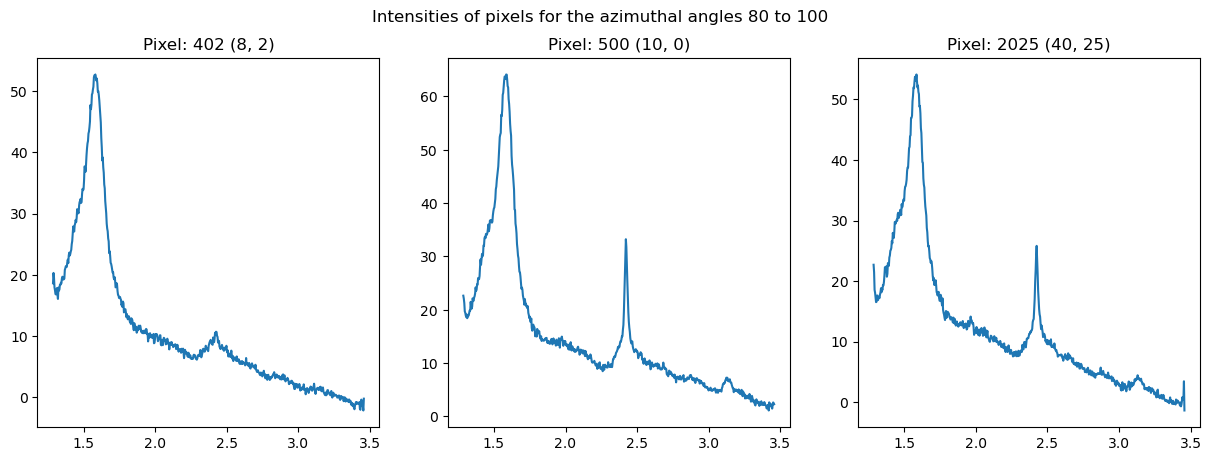

In [5]:
fig, ax = plt.subplots(1, len(pixels))
fig.suptitle('Intensities of pixels for the azimuthal angles {} to {}'.format(min_azimuthal_degree, max_azimuthal_degree))
fig.set_figwidth(15)

for i, pixel in enumerate(pixels):
    ax[i].plot(data['q'], data['I'][pixel])
    ax[i].set_title('Pixel: {} ({}, {})'.format(pixel, pixels_to_frame[0][i], pixels_to_frame[1][i]))

In the next step we will try to find the peaks of each pixel's plot.

To find the peaks we first filter the intensity data to smoothen the curve to easier find the "real" peaks and not just noise. For this we use the `scipy.signal` library method `medfilt`. The parameter `kernel_size` specifies how much the data should be smoothened and must be set by the user. (I saw that Edvin used another method for this, I don't know which one is best.)

The next step is to find the actual peaks. We continue to use the `scipy.signal` library but with the method `find_peaks`. This method takes a bunch of different optional parameters to tune the search. I have just tried some randomly and found that these two seems to work reasonable well.

This step is to be able to tweak the parameters. When we are happy with the peaks found for the pixels we will move on to examine the full sample. 

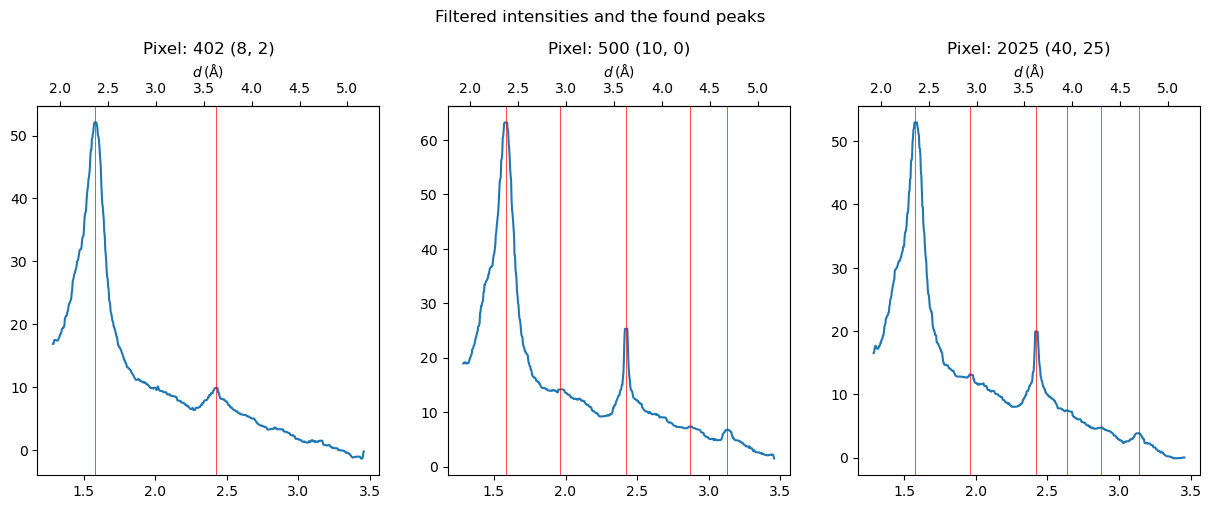

In [6]:
kernel_size = 11
I_filtered = []
for pixel in pixels:
    I_filtered.append(signal.medfilt(data['I'][pixel], kernel_size))

distance = 60
width = 4
peak_indices = []
for intensity in I_filtered:
    peak_indices.append(signal.find_peaks(intensity, distance=distance, width=width)[0])

fig, ax = plt.subplots(1, len(pixels))
fig.suptitle('Filtered intensities and the found peaks', y = 1.08)
fig.set_figwidth(15)

for i in range(len(pixels)):
    secax = ax[i].secondary_xaxis('top', functions = (lambda x: 2 * np.pi / x, lambda x: x / (2 * np.pi)))
    secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
    ax[i].plot(data['q'], I_filtered[i])
    ax[i].set_title('Pixel: {} ({}, {})'.format(pixels[i], pixels_to_frame[0][i], pixels_to_frame[1][i]))

    for xc in peak_indices[i]:
        ax[i].axvline(x = data['q'][xc], ymin = 0, ymax = 1, c ='r', lw=0.5)

Now that we have found parameters that seem to find the peaks we are interested in for a few samples we will apply it to the whole sample. This will give us some idea of how the intensity plot shape is varied across the sample. If the number of peaks found is consistent we should have more confidence to use the sample average when analyzing the intensity peaks.

In this section we create a dictionary `number_of_peaks` on the form `{int, array[int]}` where the key are the number of peaks found and the corresponding value an array stores the image indices. This allows for further inspection of pixels that diverge from the rest of the sample.

Note that we only calculate the number of peaks of pixels that are not in the background.

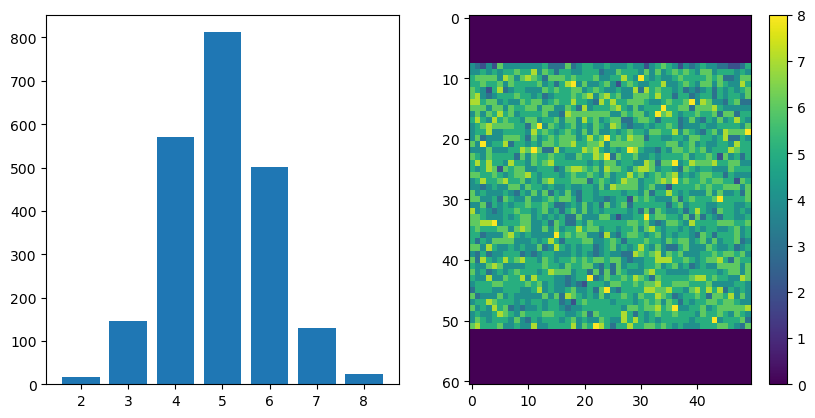

In [7]:
num_peaks = dict()
peaks_found = np.zeros(data['I'].shape[0])
for i in range(data['I'].shape[0]):
    if i in data['background_pixels']:
        continue
    else:
        number_peaks_found = len(signal.find_peaks(signal.medfilt(data['I'][i], kernel_size), distance=distance, width=width)[0])
        pixel_indices = num_peaks.get(number_peaks_found, [])
        pixel_indices.append(i)
        num_peaks[number_peaks_found] = pixel_indices
        peaks_found[i] = number_peaks_found

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

bar_plot = [len(i) for i in num_peaks.values()]
ax1.bar(num_peaks.keys(), bar_plot)

peaks_found_flipped = np.reshape(peaks_found, (data['shape'][0], data['shape'][1]))
peaks_found_flipped[1::2,:] = peaks_found_flipped[1::2,::-1]

image = ax2.imshow(peaks_found_flipped, interpolation='None', aspect='auto')
plt.colorbar(image, ax=ax2)

In [8]:
num_peaks_found = 2
print("Pixel indices where {} peaks were found: {}".format(num_peaks_found, num_peaks[num_peaks_found]))

Pixel indices where 2 peaks were found: [402, 404, 431, 437, 446, 447, 573, 603, 1155, 1294, 1352, 1435, 1528, 1673, 2220, 2381]


Now that we see that the shape of the intensity plots seems to be consistent over the whole sample we will calculate the sample average for all rows except the background rows and find the $q$ indices of the peaks.

Peaks: [ 87 331 460 534]


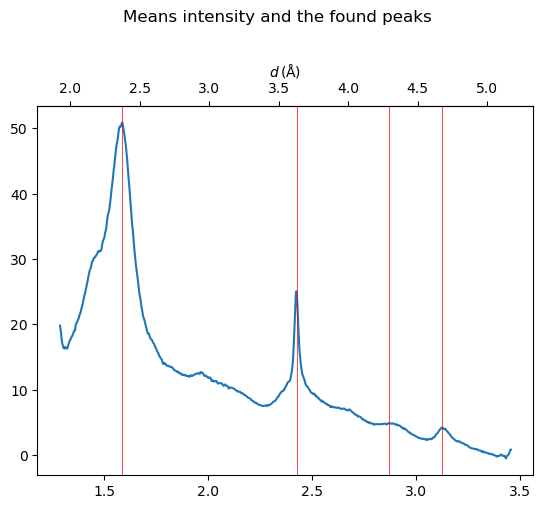

In [9]:
mean_intensity = np.mean(np.delete(data['I'], data['background_pixels'], axis=0), axis=0 )
peak_indices = signal.find_peaks(mean_intensity, distance=distance, width=width)[0]
print("Peaks: {}".format(peak_indices))

plt.plot(data['q'], mean_intensity)
plt.suptitle('Means intensity and the found peaks', y = 1.08)
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions = (lambda x: 2 * np.pi / x, lambda x: x / (2 * np.pi)))
secax.set_xlabel(r"$d \, (\mathrm{\AA})$")

for xc in peak_indices:
    ax.axvline(x = data['q'][xc], ymin = 0, ymax = 1, c ='r', lw=0.5)

# Signal processing

In this section we will briefly apply some basic signal processing techniques to the intensity data.

We start by applying a Fourier transform to the mean signal acquired from the previous section. We use the library `scipy.fft` for the Fourier transform methods. The method `rfft` computes a 1-D Fourier transform of a real valued array.

The method `rfftfreq` is used to calculate sample frequencies which allows us to plot the transformed signal. 



Text(0.5, 0.98, 'Frequency Spectrum')

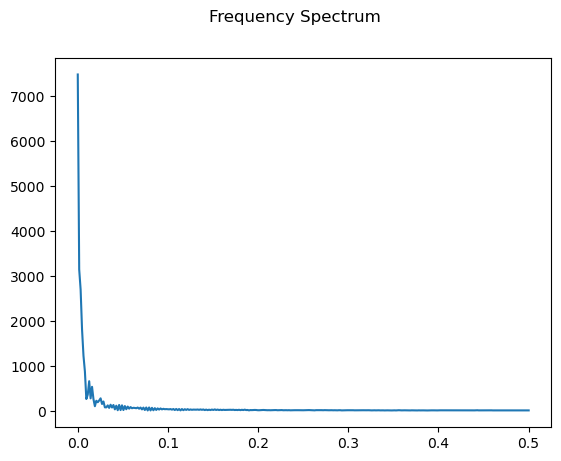

In [10]:
f_hat_dft = fft.rfft(mean_intensity)

frequencies = np.fft.rfftfreq(data['q'].size)

plt.plot(frequencies, np.abs(f_hat_dft))
plt.suptitle('Frequency Spectrum')

We see that the largest amplitudes are for the low frequencies which indicates that the signal can be expressed with only a few frequencies.

Lets invert the transform with all data points and for some lower rank.

Text(0, 0.5, 'I (A.U)')

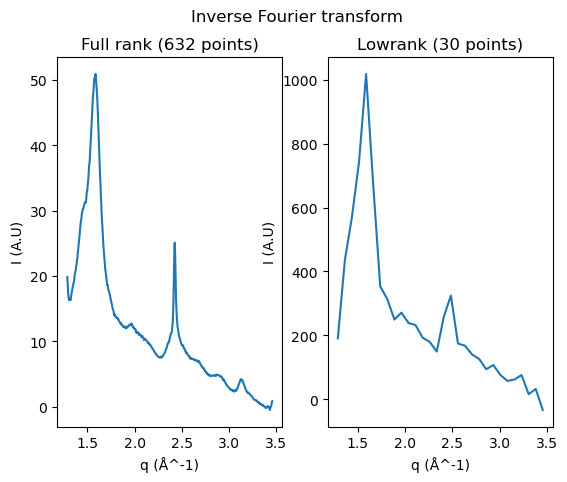

In [11]:
f_dft = fft.irfft(f_hat_dft)

low_rank = 30
f_dft_low_rank = fft.irfft(f_hat_dft, low_rank)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inverse Fourier transform')

ax1.plot(np.linspace(np.min(data['q']), np.max(data['q']), f_dft.size), f_dft)
ax1.set_title('Full rank ({} points)'.format(f_dft.size))
ax1.set_xlabel("q (Å^-1)")
ax1.set_ylabel("I (A.U)")

ax2.plot(np.linspace(np.min(data['q']), np.max(data['q']), f_dft_low_rank.size), f_dft_low_rank)
ax2.set_title('Lowrank ({} points)'.format(f_dft_low_rank.size))
ax2.set_xlabel("q (Å^-1)")
ax2.set_ylabel("I (A.U)")